# Dealer Tire Intern-Interview
## Matt Diederick

## Load Librarys

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import  MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
import scipy
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('ggplot')

## Load File Into DataFrame

In [3]:
colnames = ['RECORD_ID', 'CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'MFGCAMPNO',
            'COMPNAME','MFGNAME', 'BGMAN','ENDMAN','RCLTYPECD',
            'POTAFF', 'ODATE', 'INFLUENCED_BY', 'MFGTXT', 'RCDATE', 'DATEA',
            'RPNO', 'FMVSS', 'DESC_DEFECT', 'CONEQUENCE_DEFECT', 'CORRECTIVE_ACTION',
            'NOTES', 'RCL_CMPT_ID']

numericfields = ['RECORD_ID', 'POTAFF' ]
charfields = ['CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT',  'MFGCAMPNO',
            'COMPNAME','MFGNAME', 'RCLTYPECD',  'INFLUENCED_BY', 'MFGTXT',
              'RPNO', 'FMVSS','DESC_DEFECT' , 'CONEQUENCE_DEFECT', 'CORRECTIVE_ACTION',
            'NOTES', 'RCL_CMPT_ID']
datefields = ['BGMAN', 'ENDMAN', 'ODATE', 'RCDATE', 'DATEA', ]

def createDataFrame():
    #FILE HAD TO BE READ IN FIRST INSTEAD OF USING  pd.read_csv directly to avoid codec issues
    filepath ='FLAT_RCL.txt'
    with open(filepath, encoding='latin-1') as fp:
        line = fp.readline()
        x = []
        while line:
            line = str(line)
            x.append(line.split('\t'))
            line = fp.readline()

        df = pd.DataFrame(x, columns=colnames)
        df.set_index('RECORD_ID')

        #CAST COLUMNS TO CORRECT TYPES
        df[numericfields] = df[numericfields].apply(pd.to_numeric, errors='coerce')
        df[charfields] = df[charfields].apply(lambda x: x.astype(str))
        df[datefields] = df[datefields].apply(pd.to_datetime, errors='coerce', format='%Y%m%d')
    return df

#create dataframe
recall_df = createDataFrame()
#recall_df.head()
recall_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141430 entries, 0 to 141429
Data columns (total 24 columns):
RECORD_ID            141430 non-null int64
CAMPNO               141430 non-null object
MAKETXT              141430 non-null object
MODELTXT             141430 non-null object
YEARTXT              141430 non-null object
MFGCAMPNO            141430 non-null object
COMPNAME             141430 non-null object
MFGNAME              141430 non-null object
BGMAN                106847 non-null datetime64[ns]
ENDMAN               107084 non-null datetime64[ns]
RCLTYPECD            141430 non-null object
POTAFF               141144 non-null float64
ODATE                130615 non-null datetime64[ns]
INFLUENCED_BY        141430 non-null object
MFGTXT               141430 non-null object
RCDATE               141408 non-null datetime64[ns]
DATEA                141430 non-null datetime64[ns]
RPNO                 141430 non-null object
FMVSS                141430 non-null object
DESC_DEFECT  

## Subset Recall Data By Manufacturers

In [4]:
manufacturers = ['BMW', 'MERCEDES BENZ', 'MOPAR', 'LEXUS', 'NISSAN', 'AUDI', 'VOLKSWAGEN', 'HYUNDAI', 'HONDA', 'ACURA', 'SAAB', 'TOYOTA']
recall_df = recall_df.loc[recall_df['MAKETXT'].isin(manufacturers)]


## DROP ROWS WITH DUPLICATE CAMPAIGN NO.s

In [5]:
recall_df_by_makemodel = recall_df.drop_duplicates(['CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT'])

recall_df_by_unique_campno = recall_df.drop_duplicates(['CAMPNO'], keep='last')


## HANDLE MISSING DATA
#### DO NOT FILL DATE FIELDS SINCE DATES CANNOT BE ASSUMED FROM DATA

In [6]:
#DROP COLUMNS THAT CONTAIN MANY BLANK VALUES
recall_df_by_unique_campno.drop(['RPNO', 'FMVSS', 'MFGCAMPNO'], axis=1,  inplace=True, errors='coerc')

# Fill Missing Values In Numeric Field
recall_df_by_unique_campno['POTAFF'].fillna(method='ffill', inplace=True)

# Count Missing Data By Column
missingdata = recall_df_by_unique_campno.isnull().sum()

print(missingdata)

C:\Users\mmdie\Anaconda3\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


RECORD_ID              0
CAMPNO                 0
MAKETXT                0
MODELTXT               0
YEARTXT                0
COMPNAME               0
MFGNAME                0
BGMAN                354
ENDMAN               347
RCLTYPECD              0
POTAFF                 0
ODATE                 76
INFLUENCED_BY          0
MFGTXT                 0
RCDATE                 2
DATEA                  0
DESC_DEFECT            0
CONEQUENCE_DEFECT      0
CORRECTIVE_ACTION      0
NOTES                  0
RCL_CMPT_ID            0
dtype: int64


C:\Users\mmdie\Anaconda3\lib\site-packages\pandas\core\generic.py:6120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## PLOT RECALLS BY MANUFACTURER

MAKETXT
BMW              353
HONDA            310
NISSAN           295
MERCEDES BENZ    289
TOYOTA           287
VOLKSWAGEN       265
HYUNDAI          179
AUDI             131
SAAB              99
ACURA             70
LEXUS             64
MOPAR              5
Name: CAMPNO, dtype: int64


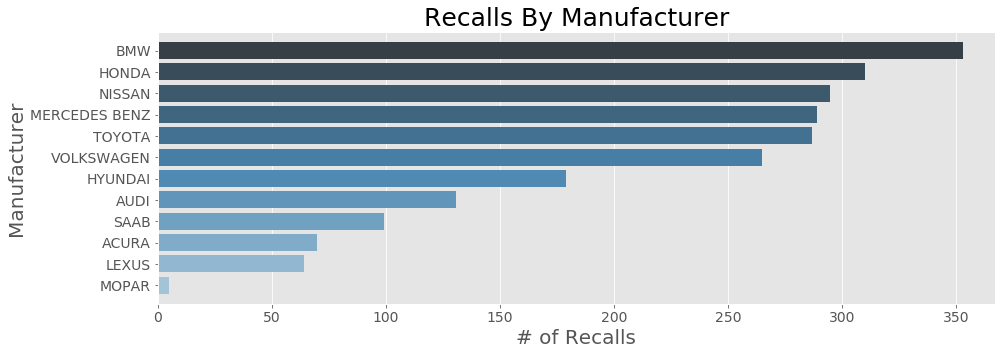

In [11]:
recalls_by_make = recall_df_by_unique_campno.groupby('MAKETXT').count()['CAMPNO']
recalls_by_make = recalls_by_make.sort_values(ascending=False)
print(recalls_by_make)

plt.figure(figsize=(15,5))
plt.tick_params(labelsize=14)
ax = sns.barplot(x=recalls_by_make.values, y=recalls_by_make.index, palette="Blues_d")
ax.set_xlabel('# of Recalls', fontsize=20)
ax.set_ylabel('Manufacturer', fontsize=20)
ax.set_title('Recalls By Manufacturer', fontsize=25)
ax.margins(.04)


plt.show()

### PLOT NUMBER OF VECHICLES AFFECTED BY RECALLS PER YEAR

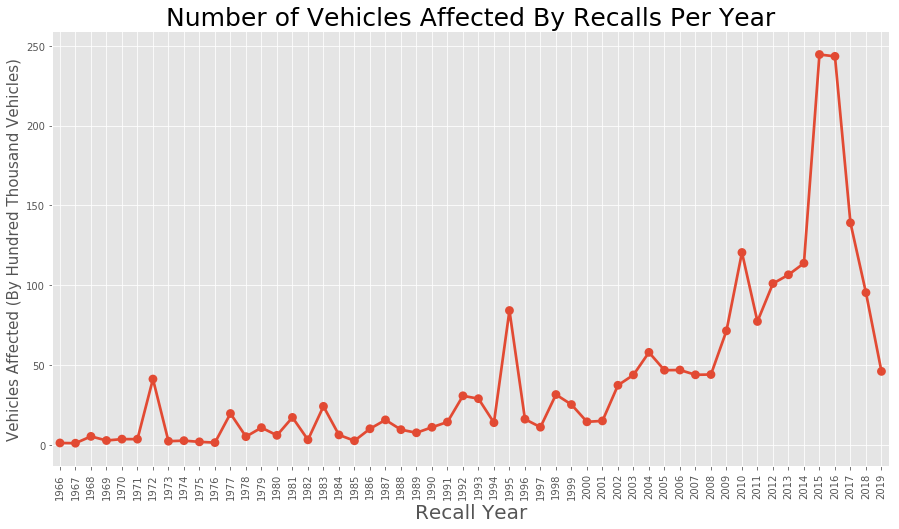

In [12]:
vehiclesaffectedperyear = recall_df_by_unique_campno['POTAFF'].groupby(recall_df_by_unique_campno.RCDATE.dt.year).sum()

plt.figure(figsize=(15,8))

ax = sns.pointplot(x=vehiclesaffectedperyear.index, y=(vehiclesaffectedperyear.values/100000))
ax.set_xticklabels(range(1966, 2020), rotation=90)
ax.set_xlabel('Recall Year', fontsize=20)
ax.set_ylabel('Vehicles Affected (By Hundred Thousand Vehicles)', fontsize=15)
ax.set_title('Number of Vehicles Affected By Recalls Per Year', fontsize=25)
ax.grid(True)
plt.show()

### Create Column for type of recall

In [7]:
recallparts = recall_df_by_unique_campno['COMPNAME'].str.split(',|:').apply(lambda x: x[0])
recall_df_by_unique_campno['RECALLTYPE'] = recallparts


C:\Users\mmdie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### PLOT RECALL By COMP TYPE

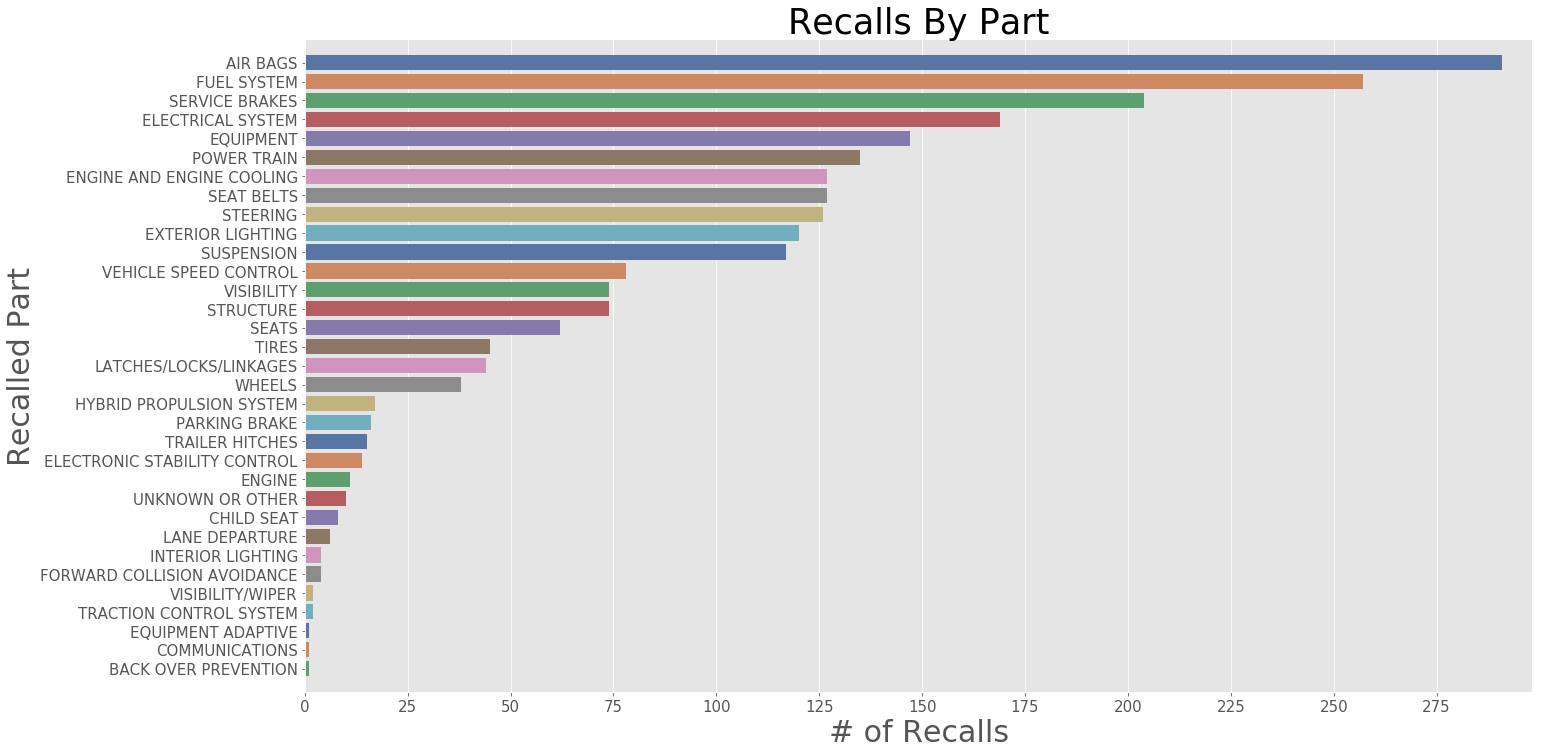

In [14]:
recalltypecounts = recall_df_by_unique_campno.groupby('RECALLTYPE').count()['CAMPNO']
recalltypecounts = recalltypecounts.sort_values(ascending=False)

plt.figure(figsize=(22,12))
plt.tick_params(labelsize=15)

ax = sns.barplot(x=recalltypecounts.values, y=recalltypecounts.index, palette="deep")
ax.set_xlabel('# of Recalls', fontsize=30)
ax.set_ylabel('Recalled Part', fontsize=30)
ax.set_title('Recalls By Part',fontsize=35)
ax.set_xticks(range(0,300,25))
ax.margins(.025)
plt.show()

### CREATE NLP MODEL USING DESCRIPTION OF DEFECT TO PREDICT TYPE OF DEFECT
#### MAY NOT BE THE MOST USEFUL EXAMPLE MEANT TO DEMONSTRATE CONCEPT
#### COULD COMBINE WITH OTHER FEATURES TO IMPROVE PERFORMANCE

In [16]:
X = recall_df_by_unique_campno['DESC_DEFECT']
y = recall_df_by_unique_campno['RECALLTYPE']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=.25)

tfidVec = TfidfVectorizer(stop_words='english', max_df=.5)
tf_train = tfidVec.fit_transform(X_train)
tf_test = tfidVec.transform(X_test)

#model = MultinomialNB()
#model = LogisticRegression()
model = SVC()
#model = RandomForestClassifier()

print("Training Model ... ")
#params = {"n_estimators":[25, 50,100,150], "max_depth": [5,10,15,20], "max_features":[5,10,15,20]}
params = {"C":[1,2,3], "gamma":[.1,.2,.5]}
gridsearchModel = GridSearchCV(model, params, cv=5)
gridsearchModel.fit(tf_train, y_train)

preds_tr = gridsearchModel.predict(tf_train)
acc_tr = np.sum(preds_tr == y_train) / len(y_train)

preds = gridsearchModel.predict(tf_test)
acc_test = np.sum(preds == y_test) / len(y_test)

print("TRAINING ACCURACY : {}".format(acc_tr))
print("TEST ACCURACY : {}".format(acc_test))
print("OPTIMAL MODEL PARAMS: {}".format(gridsearchModel.best_params_))
print("MODEL IS OVERFITTING")

Training Model


C:\Users\mmdie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\mmdie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


TRAINING ACCURACY : 0.9198863636363637
TEST ACCURACY : 0.6933560477001703
OPTIMAL MODEL PARAMS: {'C': 3, 'gamma': 0.2}
MODEL IS OVERFITTING


### Predict Make of Vehicle From Recall Information

In [9]:
# Set Features and Targets
y = recall_df_by_unique_campno['MAKETXT']
X = recall_df_by_unique_campno.drop(['RECORD_ID', 'COMPNAME',
       'MFGNAME', 'BGMAN', 'ENDMAN', 'ODATE',
        'RCDATE', 'DATEA', 'CONEQUENCE_DEFECT',
       'CORRECTIVE_ACTION', 'NOTES', 'RCL_CMPT_ID', 'MAKETXT'], axis=1)

#Create TFIDF Features
tfidVec = TfidfVectorizer(stop_words='english', max_df=.7, analyzer='word')
tf = tfidVec.fit_transform(X['DESC_DEFECT'])

# Combine TFIDF Features and X Features
df2 = pd.DataFrame(tf.toarray(), columns=tfidVec.get_feature_names())
X = pd.get_dummies(X)
result = pd.concat([X.reset_index(),df2.reset_index()], axis=1, sort=False)
result =result.loc[:,~result.columns.duplicated()]
X = result.to_sparse()

#CREATE PCA FEATURES
pca = PCA(n_components=10)
comps = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(comps,y, test_size=.25)

#Create Model with Grid Search
model = RandomForestClassifier()
params = {"n_estimators":[10,8], "max_depth": [8,3], "max_features":[5,3]}
forest_cv = GridSearchCV(model, params, cv=5)
forest_cv.fit(X_train, y_train)

#Predict Train and Test
preds_train=  forest_cv.predict(X_train)
preds_test =forest_cv.predict(X_test)
acc_tr = metrics.accuracy_score(y_train, preds_train)
acc_ts= metrics.accuracy_score(y_test, preds_test)
print("TRAINING ACCURACY: {} ".format(acc_tr))
print("TESTING ACCURACY: {} ".format(acc_ts))



C:\Users\mmdie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


TRAINING ACCURACY: 0.8903409090909091 
TESTING ACCURACY: 0.8671209540034072 
